In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import itertools

In [2]:
np.random.seed(0)

In [3]:
def operators(s):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    ops = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))

    jindex = 0
    for index in range(n_var):
        ops[:,jindex] = s[:,index]
        jindex +=1

    for index in range(n_var-1):
        for index1 in range(index+1,n_var):
            ops[:,jindex] = s[:,index]*s[:,index1]
            jindex +=1
            
    return ops

In [4]:
def energy_ops(ops,w):
    return np.sum(ops*w[np.newaxis,:],axis=1)

In [5]:
def generate_seqs(n_var,n_seq,n_sample=30,g=2.0):
    samples = np.random.choice([1.0,-1.0],size=(n_seq*n_sample,n_var),replace=True)
    ops = operators(samples)
    n_ops = ops.shape[1]

    #w_true = g*(np.random.rand(ops.shape[1])-0.5)/np.sqrt(float(n_var))
    w_true = np.random.normal(0.,g/np.sqrt(n_var),size=n_ops)

    sample_energy = energy_ops(ops,w_true)
    p = np.exp(sample_energy)
    p /= np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    
    return w_true,samples[out_samples] #,p[out_samples],sample_energy[out_samples]

In [6]:
def eps_machine(s,eps_scale=.01,max_iter=151,alpha=0.1):
    MSE = np.zeros(max_iter)
    KL = np.zeros(max_iter)
    E_av = np.zeros(max_iter)
    
    n_seq,n_var = s.shape
    ops = operators(s)
    n_ops = ops.shape[1]
    cov_inv = np.eye(ops.shape[1])

    np.random.seed(13)
    w = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
    for i in range(max_iter):        
        energies_w = energy_ops(ops,w)
        probs_w = np.exp(-energies_w*(1-eps_scale))
        z_data = np.sum(probs_w)
        probs_w /= z_data
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
        
        #if iterate%int(max_iter/5.0)==0:
        E_exp = (probs_w*energies_w).sum()
        KL[i] = -E_exp - np.log(z_data) + np.sum(np.log(np.cosh(w*eps_scale)))
        E_av[i] = energies_w.mean()
        MSE[i] = ((w-w_true)**2).mean()
        #print(RMSE[i])
        
        #print(eps_scale,iterate,nplin.norm(w-w_true),RMSE,KL,E_av)

        sec_order = w*eps_scale
        w += alpha*cov_inv.dot((ops_expect_w - sec_order))
        
    #print('final ',eps_scale,iterate,nplin.norm(w-w_true))
    
    return MSE,KL,E_av

In [7]:
max_iter = 151

n_var,n_seq = 25,1000
g = 2.

w_true,seqs = generate_seqs(n_var,n_seq,g=g)

#eps_list = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.]
eps_list = np.linspace(0.2,1.,17,endpoint=True)
n_eps = len(eps_list)

#w = np.zeros((n_eps,max_iter,))
MSE = np.zeros((n_eps,max_iter))
KL = np.zeros((n_eps,max_iter))
E_av = np.zeros((n_eps,max_iter))

for i,eps in enumerate(eps_list):     
    print('eps:',eps)
    MSE[i,:],KL[i,:],E_av[i,:] = eps_machine(seqs,eps_scale=eps,max_iter=max_iter)

eps: 0.2
eps: 0.25
eps: 0.30000000000000004
eps: 0.35000000000000003
eps: 0.4
eps: 0.45
eps: 0.5
eps: 0.55
eps: 0.6000000000000001
eps: 0.65
eps: 0.7
eps: 0.75
eps: 0.8
eps: 0.8500000000000001
eps: 0.9000000000000001
eps: 0.95
eps: 1.0


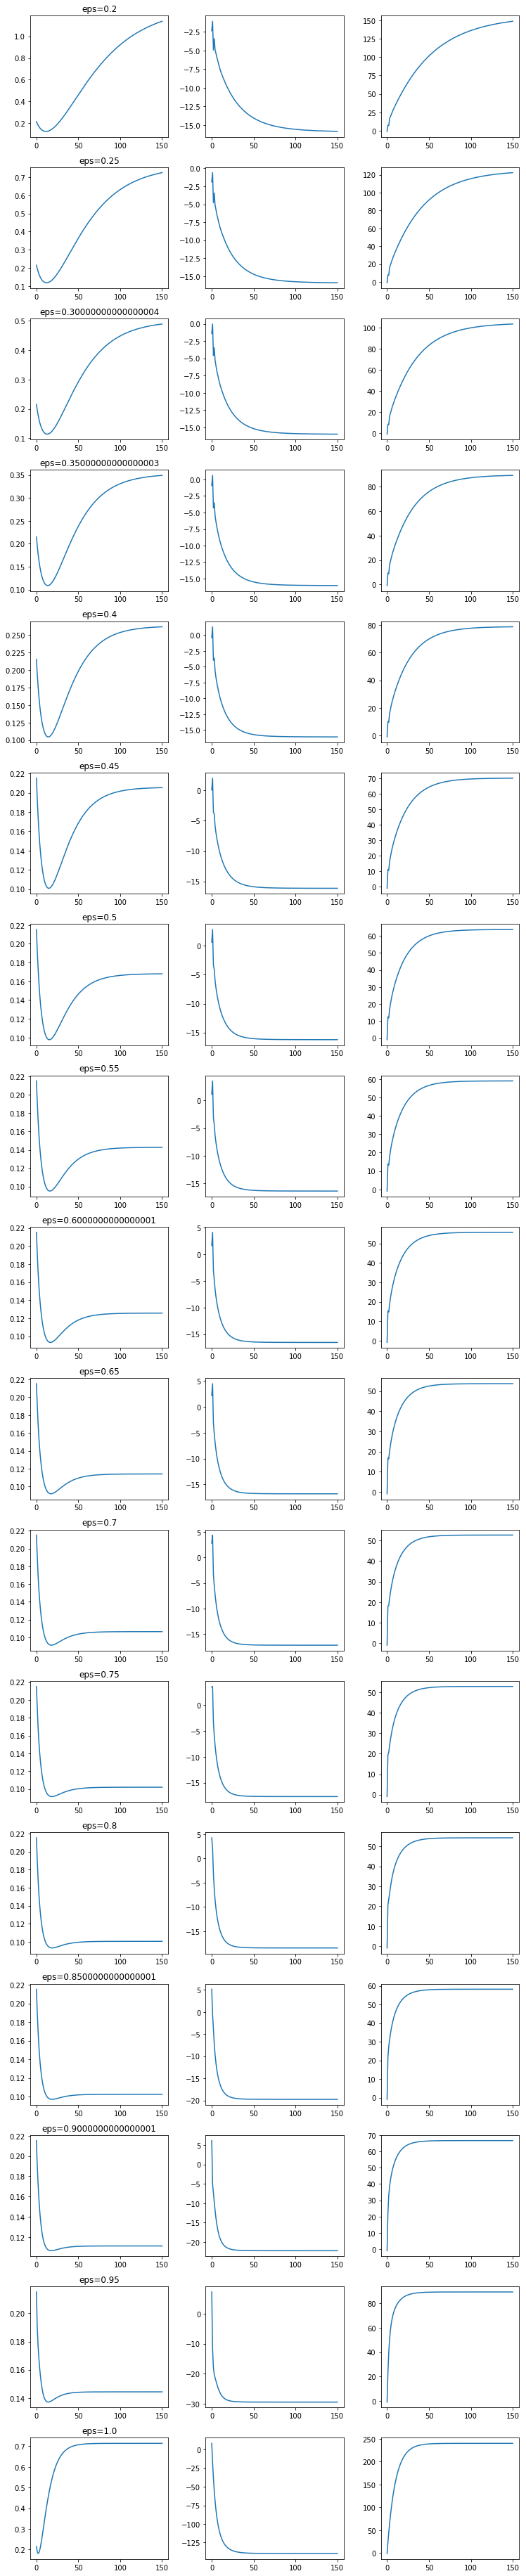

In [8]:
nx,ny = 3,n_eps
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*3))

#lims = [np.min([w_true, w]), np.max([w_true, w])]

for i,eps in enumerate(eps_list):
    ax[i,0].set_title('eps=%s'%eps)
    ax[i,0].plot(MSE[i])
    ax[i,1].plot(KL[i])
    ax[i,2].plot(E_av[i])
    #ax[i,0].set_ylim([0,0.01])
    #ax[i,1].set_ylim([-8,-5])
    #ax[i,2].set_ylim([1,2.5])
    
    #ax[0,1].set_ylim([-6.6,-6.1])
    #ax[1,1].set_ylim([-6.8,-6.3])
    #ax[2,1].set_ylim([-7.2,-7.0])
    #ax[3,1].set_ylim([-7.5,-7.3])
    
plt.tight_layout(h_pad=1, w_pad=1.5)
#plt.savefig('fig.pdf', format='pdf', dpi=100)

In [9]:
i,j = np.unravel_index(MSE.argmin(), MSE.shape)
eps0 = eps_list[i]
print('optimal eps:',eps0)

optimal eps: 0.7


In [10]:
for i,eps in enumerate(eps_list):
    j0 = np.argmin(MSE[i,:])
    j = np.argmin(KL[i,:])
       
    print(i,eps,MSE[i,j0],MSE[i,j],KL[i,j],np.max(E_av[i,:]))    

0 0.2 0.12480066564277846 1.1389596782239315 -15.842074685194683 148.66856988659663
1 0.25 0.1189778657491997 0.7242344328338227 -15.927536601584437 122.3516693838001
2 0.30000000000000004 0.11365462928270054 0.4892544190763946 -15.983535510571652 103.42748655098748
3 0.35000000000000003 0.10889527654922172 0.3490980454411743 -16.03234869163613 89.37291837862149
4 0.4 0.10454573891908017 0.26176790955856727 -16.083534018486663 78.63046440112804
5 0.45 0.1008238556734884 0.20537168024728392 -16.144449578125737 70.24589831729463
6 0.5 0.09769317742963997 0.1679636668904713 -16.228887360662164 63.74023366526666
7 0.55 0.09506408534895293 0.1427429407281919 -16.35942401362151 58.96693880652381
8 0.6000000000000001 0.09307498516906748 0.12560451741544154 -16.55167483366788 55.697437258299075
9 0.65 0.09172255619631645 0.114004178658548 -16.817960415050088 53.63448580258807
10 0.7 0.09109781518841602 0.10640525848975056 -17.184080879755257 52.637724622821565
11 0.75 0.09142516711698505 0.101